## Income/Trend Analysis

1. The goal of this notebook is to find a way to connect and integrate my google calendar data that I have used to scheudle clients over the past couple years and perform an exploratory analysis to see what trends occur in scheduling and income.
2. The goal with that data will be to build a forecasting model to predict how income will change across different times of the year

In [25]:
from icalendar import Calendar
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller



email='jaredaperez1995@gmail.com'

In [26]:
# Open the .ics file
with open(f'{email}.ics', 'r') as f:
    cal = Calendar.from_ical(f.read())

counter=0
for component in cal.walk():
    if component.name == "VEVENT":
        # Access the event details
        start_date = component.get('dtstart')
        end_date = component.get('dtend')
        summary = component.get('summary')
        description = component.get('description')

        # Ensure start_date and end_date are not None before accessing 'dt' attribute
        if start_date is not None:
            start_date = start_date.dt
        if end_date is not None:
            end_date = end_date.dt

        # Print event details
        print(f"Start: {start_date}, End: {end_date}, Summary: {summary}, Description: {description}")
        counter+=1
        print(counter)

Start: 2019-06-29 17:45:00+00:00, End: 2019-06-29 19:25:00+00:00, Summary: Flight to Zadar (EW 974), Description: Eurowings flight 974
Cologne CGN 7:45pm (local time) - Zadar ZAD 9:25pm (local time)

Confirmation number: QJLM7B
1
Start: 2019-06-07 19:00:00+00:00, End: 2019-06-07 20:00:00+00:00, Summary: Phone Interview Bryant Sharifi, Description: None
2
Start: 2019-08-03 05:15:00+00:00, End: 2019-08-03 06:15:00+00:00, Summary: Spider-Man: Far From Home (2019) Spider-Man: Far From Home (2019), Description: Spider-Man: Far From Home (2019) Spider-Man: Far From Home (2019)
AMC Bay Street 16, Emeryville, California, United States, 94608

Confirmation number: A0235373853
3
Start: 2019-08-19 20:00:00+00:00, End: 2019-08-19 20:15:00+00:00, Summary: iCIMS Opportunities with arocchio, Description: Event Name: iCIMS Opportunities
Event Description: I will call you within 5 minutes of your time chosen! Keep an eye out for a 704 area code as I will be calling from North Carolina. 
Date & Time: 01

### Modify previous script to only search for 'Google Meet' events since those are how I schedule clients

In [27]:

pt_sessions=[]

# Open the .ics file
with open(f'{email}.ics', 'r') as f:
    cal = Calendar.from_ical(f.read())

counter=0
for component in cal.walk():
    if component.name == "VEVENT":
        # Access the event details
        start_date = component.get('dtstart')
        end_date = component.get('dtend')
        summary = component.get('summary')
        description = component.get('description')

        # Ensure start_date and end_date are not None before accessing 'dt' attribute
        if start_date is not None:
            start_date = start_date.dt
        if end_date is not None:
            end_date = end_date.dt

        # Check if the event description contains a Google Meet link
        if description is not None and 'Join with Google Meet' in description or 'PT' in summary:
            # Print event details
            print(f"Start: {start_date}, End: {end_date}, Summary: {summary}")
            pt_sessions.append([start_date.date(),end_date.date(),summary])
            counter+=1
            print(counter)
        


Start: 2020-06-22 15:00:00+00:00, End: 2020-06-22 16:00:00+00:00, Summary: PT-E
1
Start: 2020-06-26 15:00:00+00:00, End: 2020-06-26 16:00:00+00:00, Summary: PT-E
2
Start: 2020-06-29 15:00:00+00:00, End: 2020-06-29 16:00:00+00:00, Summary: PT-E
3
Start: 2020-07-01 16:30:00+00:00, End: 2020-07-01 17:30:00+00:00, Summary: PT-E
4
Start: 2020-07-29 09:30:00-07:00, End: 2020-07-29 10:30:00-07:00, Summary: PT-E
5
Start: 2020-07-24 16:30:00+00:00, End: 2020-07-24 17:30:00+00:00, Summary: PT Jessica
6
Start: 2020-07-27 22:00:00+00:00, End: 2020-07-27 23:00:00+00:00, Summary: PT Masha 2
7
Start: 2020-07-21 16:30:00+00:00, End: 2020-07-21 17:30:00+00:00, Summary: PT-Jessica
8
Start: 2020-06-23 16:00:00-07:00, End: 2020-06-23 17:00:00-07:00, Summary: PT
9
Start: 2020-07-07 09:30:00-07:00, End: 2020-07-07 10:30:00-07:00, Summary: PT
10
Start: 2020-07-28 16:30:00+00:00, End: 2020-07-28 17:30:00+00:00, Summary: PT-Jessica
11
Start: 2020-07-06 08:00:00-07:00, End: 2020-07-06 09:00:00-07:00, Summary: P

In [28]:
pt_sessions_df=pd.DataFrame(pt_sessions,columns=['start_date','end_date','summary'])
pt_sessions_df=pt_sessions_df.dropna()
pt_sessions_df

,start_date,end_date,summary
0,2020-06-22,2020-06-22,PT-E
1,2020-06-26,2020-06-26,PT-E
2,2020-06-29,2020-06-29,PT-E
3,2020-07-01,2020-07-01,PT-E
4,2020-07-29,2020-07-29,PT-E
...,...,...,...
1534,2023-05-29,2023-05-29,PT
1535,2023-06-02,2023-06-02,PT
1536,2023-05-27,2023-05-27,PT-Daniel
1537,2023-06-03,2023-06-03,PT-Dino


### Lets filter out non-client events

In [29]:
events=pt_sessions_df['summary'].unique()
events

array([vText('b'PT-E''), vText('b'PT Jessica''), vText('b'PT Masha 2''),
       vText('b'PT-Jessica''), vText('b'PT''), vText('b'PT-Linda''),
       vText('b'PT-DQ''), vText('b'Juan Carlos''),
       vText('b'Alfano\\, / Jared''), vText('b'PT-Yelena''),
       vText('b'Fam Chat''), vText('b'Chat''), vText('b'Masha-PT''),
       vText('b'Supervisory Team Meet''), vText('b'Yelena / Jared''),
       vText('b'PT Arne''), vText('b'PT-Arne''), vText('b'Dino-Hold''),
       vText('b'PT-Ilya''), vText('b'PT-misha''), vText('b'PT-Misha''),
       vText('b'PT-Dino''), vText('b'Aida / Jared''),
       vText('b'PT-Masha''), vText('b'PT-Nick Wong''), vText('b'PT 1/5''),
       vText('b'Catch Up''), vText('b'PT-Jana''),
       vText('b'Adam / Jared''), vText('b'PT-Yelena 3/5''),
       vText('b'PT-Yelena 5/5''), vText('b'PT-Yelena 2/6''),
       vText('b'PT-Yelena 5/6''), vText('b'Yelena 4/5''),
       vText('b'Yelena 3/6''), vText('b'Yelena 4/6''),
       vText('b'Yelena 6/6''), vText('b'Yelena''),

Instead of doing a regex to exclude non-sessions, lets filter out the sessions by things we know are in them

In [30]:
events_df=pd.DataFrame(events,columns=['summary'])
events_df

,summary
0,PT-E
1,PT Jessica
2,PT Masha 2
3,PT-Jessica
4,PT
...,...
137,PT-Alan
138,PT 1/2
139,Jared <> Kiran: Digital Twin
140,PT-Nick


In [31]:
non_pt_events=events_df[~events_df['summary'].str.contains('PT', na=False)]
non_pt_events

,summary
7,Juan Carlos
8,"Alfano, / Jared"
10,Fam Chat
11,Chat
13,Supervisory Team Meet
...,...
131,VBA
133,SuckIt NZ Hack-a-Thon
134,Fuck we still didn't talk about Brooklyn 99!!!
135,Nat


### Manual screening of Meet events that do not have 'PT' to see which are and arent

In [32]:
for event in non_pt_events.iterrows():
    print(event[1]['summary'])

Juan Carlos
Alfano, / Jared
Fam Chat
Chat
Supervisory Team Meet
Yelena / Jared
Dino-Hold
Aida / Jared
Catch Up
Adam / Jared
Yelena 4/5
Yelena 3/6
Yelena 4/6
Yelena 6/6
Yelena
Connect
Josh 3/3
Hold
Sonia
Karol
Josh 1/4
Josh 2/4
Josh 3/4
Introduction & Connect
Catch up with the Homie
Jordan Lecture
Yelena 2/7
Yelena 4/7
Yelena 6/7
Yelena 1/7
Yelena 7/7
Andrew Call
Dassi
Max
Nick Wong
Game Night
Igor
Jared/yelena 4/7
Yelena 3/7
Yelena 5/7
Jared/Yeleba
Masha
Jared <> Orreco catch up
Jared/yelena 6/7
Call
Supervisor Team Meeting
Jared Perez and Sahana Gopal 
Weekly Shoot The Shit
Jared / Karol
It's been too long
Jared A Perez Melendez: DSML Initial Video Interview
Fam talk
Jared Perez and Alex McCarthy
Jared Kim connect
Jared Perez Interview
Career Advice
casey / Jared
Arne / Jared
Jared
Jared Perez and Tanya Chukau
We still need to discuss Brooklyn 99
Anya
Alyssa / Jared/Murphy/Maybe Nick
VBA
SuckIt NZ Hack-a-Thon
Fuck we still didn't talk about Brooklyn 99!!!
Nat
Jared <> Kiran: Digital T

In [33]:
#Manually screened out non-PT events by determining which events to include in the analysis
additiona_pt_events=['Juan Carlos', 'Alfano/Jared', 'Yelena/Jared', 'Yelena', 'Sonia', 'Karol', 'Josh', 'Dassi', 'Max', 'Nick', 'Arne / Jared', 'Anya', "Nat"]

In [34]:
#Change the PT events that are not appropriately labeled to correct events
pt_sessions_df.loc[pt_sessions_df['summary'].isin(additiona_pt_events), 'summary']

35       Juan Carlos
178           Yelena
204            Sonia
205            Karol
304           Yelena
347            Dassi
349              Max
367              Max
518            Dassi
519            Dassi
520            Dassi
521            Dassi
1085     Juan Carlos
1105    Arne / Jared
1316            Anya
1424             Nat
Name: summary, dtype: object

In [35]:
pt_sessions_df.loc[pt_sessions_df['summary'].isin(additiona_pt_events), 'summary']='PT'

In [36]:
pt_sessions_df=pt_sessions_df[pt_sessions_df['summary'].str.contains('PT')]
pt_sessions_df

,start_date,end_date,summary
0,2020-06-22,2020-06-22,PT-E
1,2020-06-26,2020-06-26,PT-E
2,2020-06-29,2020-06-29,PT-E
3,2020-07-01,2020-07-01,PT-E
4,2020-07-29,2020-07-29,PT-E
...,...,...,...
1534,2023-05-29,2023-05-29,PT
1535,2023-06-02,2023-06-02,PT
1536,2023-05-27,2023-05-27,PT-Daniel
1537,2023-06-03,2023-06-03,PT-Dino


In [37]:
pt_sessions_df.sort_values(by=['start_date'], inplace=True)

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_1015/950510325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pt_sessions_df.sort_values(by=['start_date'], inplace=True)


In [38]:
pt_sessions_df=pt_sessions_df.reset_index(drop=True)
pt_sessions_df=pt_sessions_df.drop(index=0)
pt_sessions_df

,start_date,end_date,summary
1,2020-05-29,2020-05-29,PT
2,2020-05-29,2020-05-29,PT
3,2020-05-29,2020-05-29,PT
4,2020-06-01,2020-06-01,PT
5,2020-06-05,2020-06-05,PT
...,...,...,...
1387,2023-06-03,2023-06-03,PT-Dino
1388,2023-06-14,2023-06-14,PT
1389,2023-06-16,2023-06-16,PT-Nick
1390,2023-06-19,2023-06-19,PT-Nick Wong


In [39]:
df_counts=pt_sessions_df.groupby('end_date')['summary'].count().sort_values(ascending=False)
pt_sessions_df.groupby('end_date')['summary'].count().sort_values(ascending=False)

end_date
2023-02-24    12
2022-09-28     7
2023-03-03     7
2023-02-27     6
2022-12-16     6
              ..
2020-12-21     1
2022-04-02     1
2022-03-27     1
2020-12-23     1
2023-06-21     1
Name: summary, Length: 674, dtype: int64

<Axes: xlabel='end_date'>

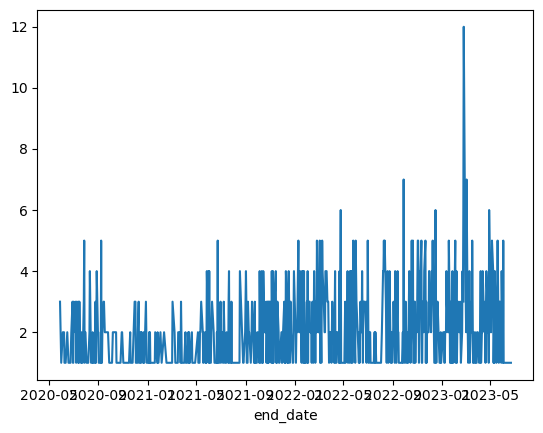

In [40]:
# Plot this data
df_counts.plot(kind='line')

### Super messy and hard to interpret by the day. Going to resmaple to weekly freqeuncy

In [41]:
pt_sessions_df=pt_sessions_df.reset_index(drop=True)
pt_sessions_df

,start_date,end_date,summary
0,2020-05-29,2020-05-29,PT
1,2020-05-29,2020-05-29,PT
2,2020-05-29,2020-05-29,PT
3,2020-06-01,2020-06-01,PT
4,2020-06-05,2020-06-05,PT
...,...,...,...
1386,2023-06-03,2023-06-03,PT-Dino
1387,2023-06-14,2023-06-14,PT
1388,2023-06-16,2023-06-16,PT-Nick
1389,2023-06-19,2023-06-19,PT-Nick Wong


In [42]:
pt_sessions_df['end_date']=pd.to_datetime(pt_sessions_df['end_date'])

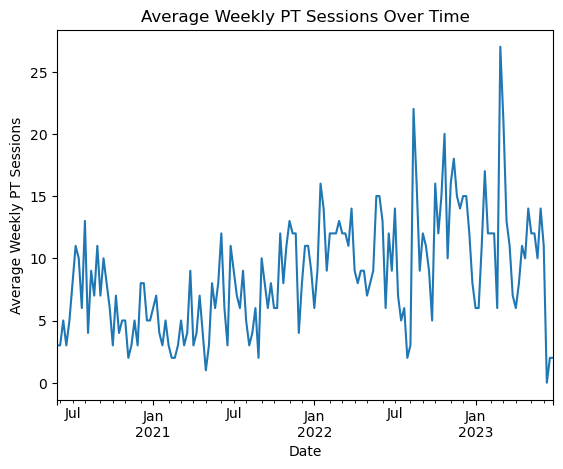

In [43]:
# Set 'start_date' as index
pt_sessions_df.set_index('end_date', inplace=True)

# Resample to weekly frequency and calculate mean
weekly_data = pt_sessions_df.resample('W').count()

# Plot
weekly_data['summary'].plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Average Weekly PT Sessions')
plt.title('Average Weekly PT Sessions Over Time')

plt.savefig('average_weekly_pt_sessions_over_time.png')
plt.show()



### Develop a forecasting model to predict income

1. I will try a few different approaches (fbprophet, ARIMA, SARIMA) to forecast business trends and compare results

In [44]:
weekly_data

,start_date,summary
end_date,,
2020-05-31,3,3
2020-06-07,3,3
2020-06-14,5,5
2020-06-21,3,3
2020-06-28,5,5
...,...,...
2023-05-28,14,14
2023-06-04,11,11
2023-06-11,0,0


In [45]:
pt_sessions_df.groupby('end_date')['summary'].count().sort_values(ascending=False)

end_date
2023-02-24    12
2022-09-28     7
2023-03-03     7
2023-02-27     6
2022-12-16     6
              ..
2020-12-21     1
2022-04-02     1
2022-03-27     1
2020-12-23     1
2023-06-21     1
Name: summary, Length: 674, dtype: int64

In [46]:
weekly_data

,start_date,summary
end_date,,
2020-05-31,3,3
2020-06-07,3,3
2020-06-14,5,5
2020-06-21,3,3
2020-06-28,5,5
...,...,...
2023-05-28,14,14
2023-06-04,11,11
2023-06-11,0,0


In [48]:
#Dropping the last few rows of the dataframe which may skew the data
weekly_data=weekly_data[:-3]
weekly_data

,start_date,summary
end_date,,
2020-05-31,3,3
2020-06-07,3,3
2020-06-14,5,5
2020-06-21,3,3
2020-06-28,5,5
...,...,...
2023-05-07,12,12
2023-05-14,12,12
2023-05-21,10,10


In [49]:
dftest = adfuller(weekly_data['summary'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)


Test Statistic                  -2.562903
p-value                          0.100909
#Lags Used                       5.000000
Number of Observations Used    152.000000
dtype: float64


### Time series data is not stationary given a p-value of >.05 however after attempting a few different levels for the 'd' transformation the model's best performance was still with a 'd'=0

/Users/jaredperez/opt/miniconda3/envs/flask_blog/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


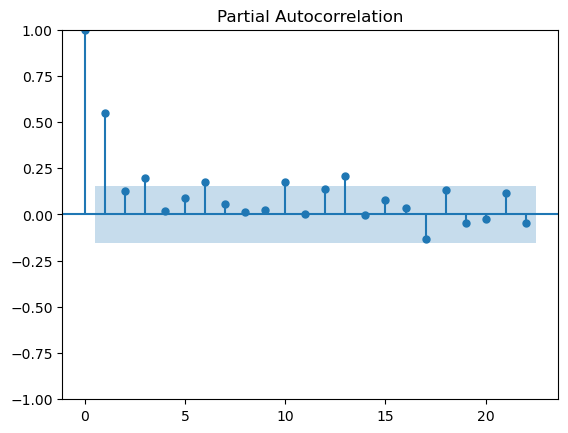

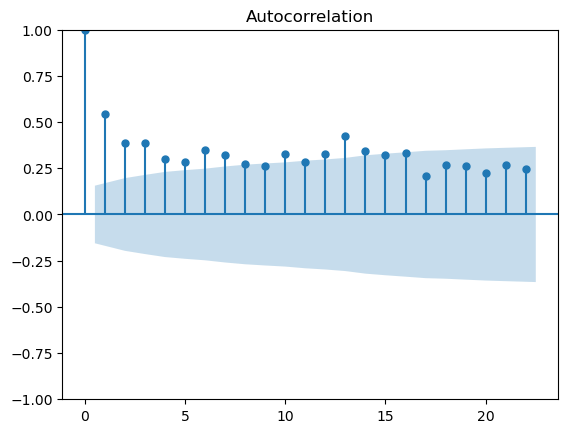

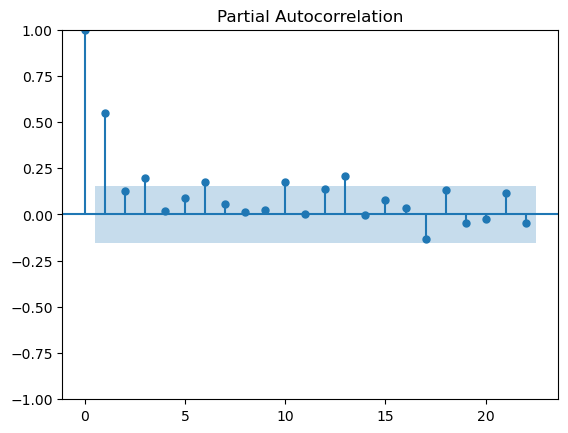

In [50]:
# ACF plot
plot_acf(weekly_data['summary'])

# PACF plot
plot_pacf(weekly_data['summary'])


In [51]:
#Auto ARIMA parameter calculation
model = auto_arima(weekly_data['summary'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(weekly_data['summary'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=906.066, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=889.871, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=863.533, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=904.089, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=853.407, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=855.297, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=857.406, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=853.157, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=862.141, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=855.149, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=855.153, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=853.481, Time=0.0

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### Arima does not seem to fit the data very well so lets instead try a SARIMAX model

1. Sarima will consider seasonality patterns which may be more appropriate for my data

2. d=0 was also reccomended by the auto_arima parameters

/Users/jaredperez/opt/miniconda3/envs/flask_blog/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98694D+00    |proj g|=  6.32548D-02


 This problem is unconstrained.



At iterate    5    f=  1.97175D+00    |proj g|=  3.77513D-03

At iterate   10    f=  1.97068D+00    |proj g|=  9.75017D-04

At iterate   15    f=  1.97050D+00    |proj g|=  2.89054D-04

At iterate   20    f=  1.97047D+00    |proj g|=  1.30173D-04

At iterate   25    f=  1.97047D+00    |proj g|=  3.05865D-04

At iterate   30    f=  1.97046D+00    |proj g|=  3.25613D-05

At iterate   35    f=  1.97046D+00    |proj g|=  3.48833D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     45      1     0     0   6.042D-06   1.970D+00
  F =   1.9704641030242804     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

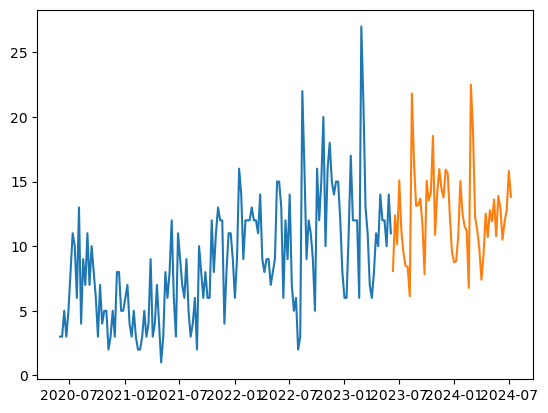

In [52]:
#Using auto ARIMA parameters
model = SARIMAX(weekly_data['summary'], order=(0, 1, 2), seasonal_order=(0, 1, 2, 52))
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(weekly_data['summary']), end=len(weekly_data['summary']) + 56)

plt.plot(weekly_data['summary'])
plt.plot(predictions)
plt.show()


In [53]:
predictions

2023-06-11     8.072349
2023-06-18    12.390162
2023-06-25    10.142773
2023-07-02    15.085837
2023-07-09    11.187249
2023-07-16     9.450450
2023-07-23     8.477235
2023-07-30     8.405174
2023-08-06     6.116027
2023-08-13    21.806831
2023-08-20    16.484059
2023-08-27    13.130338
2023-09-03    13.161262
2023-09-10    13.683490
2023-09-17    11.683497
2023-09-24     7.834323
2023-10-01    15.055704
2023-10-08    13.536824
2023-10-15    14.112626
2023-10-22    18.529302
2023-10-29    10.879577
2023-11-05    14.041361
2023-11-12    15.965946
2023-11-19    14.469705
2023-11-26    13.769892
2023-12-03    15.916538
2023-12-10    15.634855
2023-12-17    12.353187
2023-12-24     9.593752
2023-12-31     8.758905
2024-01-07     8.834306
2024-01-14    10.789821
2024-01-21    15.041350
2024-01-28    12.540965
2024-02-04    11.545112
2024-02-11    11.188026
2024-02-18     6.767210
2024-02-25    22.503290
2024-03-03    18.890531
2024-03-10    12.281930
2024-03-17    11.259292
2024-03-24     9

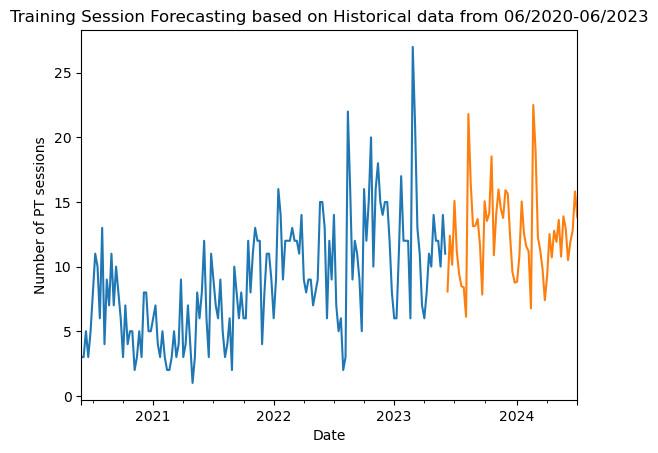

In [80]:
weekly_data['summary'].plot(kind='line')
predictions.plot(kind='line')

plt.xlabel('Date')
plt.ylabel('Number of PT sessions')
plt.title('Training Session Forecasting based on Historical data from 06/2020-06/2023')

plt.savefig('training_session_forecasting.png')
plt.show()

In [85]:
predictions_df=pd.DataFrame(predictions)
predictions_df['predictions']=predictions_df['predicted_mean'].astype(int)
predictions_df=predictions_df.drop(columns=['predicted_mean'])
predictions_df

,predictions
2023-06-11,8
2023-06-18,12
2023-06-25,10
2023-07-02,15
2023-07-09,11
2023-07-16,9
2023-07-23,8
2023-07-30,8
2023-08-06,6
2023-08-13,21


### Lets break down the predictions for the next year and compare them to historical data

In [86]:
monthly_predictions=predictions_df.resample('M').sum()
monthly_predictions

,predictions
2023-06-30,30
2023-07-31,51
2023-08-31,56
2023-09-30,44
2023-10-31,70
2023-11-30,56
2023-12-31,59
2024-01-31,45
2024-02-29,50
2024-03-31,57


In [88]:
monthly_history=weekly_data.resample('M').sum()
monthly_history

,start_date,summary
end_date,,
2020-05-31,3,3
2020-06-30,16,16
2020-07-31,35,35
2020-08-31,44,44
2020-09-30,31,31
2020-10-31,19,19
2020-11-30,18,18
2020-12-31,26,26
2021-01-31,25,25


In [89]:
monthly_predictions

,predictions
2023-06-30,30
2023-07-31,51
2023-08-31,56
2023-09-30,44
2023-10-31,70
2023-11-30,56
2023-12-31,59
2024-01-31,45
2024-02-29,50
2024-03-31,57


In [90]:
percentage_df=monthly_predictions['predictions']/monthly_predictions['predictions'].max()
percentage_df

2023-06-30    0.428571
2023-07-31    0.728571
2023-08-31    0.800000
2023-09-30    0.628571
2023-10-31    1.000000
2023-11-30    0.800000
2023-12-31    0.842857
2024-01-31    0.642857
2024-02-29    0.714286
2024-03-31    0.814286
2024-04-30    0.614286
2024-05-31    0.671429
2024-06-30    0.857143
2024-07-31    0.185714
Freq: M, Name: predictions, dtype: float64

In [94]:
percentage_df=percentage_df.drop(index='2023-06-30')
percentage_df

2023-07-31    0.728571
2023-08-31    0.800000
2023-09-30    0.628571
2023-10-31    1.000000
2023-11-30    0.800000
2023-12-31    0.842857
2024-01-31    0.642857
2024-02-29    0.714286
2024-03-31    0.814286
2024-04-30    0.614286
2024-05-31    0.671429
2024-06-30    0.857143
2024-07-31    0.185714
Freq: M, Name: predictions, dtype: float64

In [95]:
percentage_df=percentage_df.drop(index='2024-07-31')
percentage_df

2023-07-31    0.728571
2023-08-31    0.800000
2023-09-30    0.628571
2023-10-31    1.000000
2023-11-30    0.800000
2023-12-31    0.842857
2024-01-31    0.642857
2024-02-29    0.714286
2024-03-31    0.814286
2024-04-30    0.614286
2024-05-31    0.671429
2024-06-30    0.857143
Freq: M, Name: predictions, dtype: float64

### Conclusions:

1. It is hard to know if these predictions are accurate given there are plenty of sessions that are not accounted for because they did not have a 'Meet" in the calendar, however some of the general trends make sense, especially in the weekly data where there are decreases around Holidays like Christmas, Thanksgiving, and Summer.

2. In order to assess it efficacy I would need to see how it does over the next year and if it tracks generally with the real sessions serviced

3. The real value I believe is in the final dataframe which shows a relative percentage of sessions according to the highest number of sessions. 

    Assuming a month with the highest sessions is a month where most everyone shows up (100% compliance), the percentages are indicators of how much of my income I actually make in a month relative to what I would make in a given month if everyone showed up.

    This drives home the difficulties of self-employment where (exlcuding the first and last month which are likely outliers) on any given month my income can fluctuate from 60% of max to 85% of max and only once gets within 90% of everyone showing up (the month where everyone showed up). This is indicative of the highly variable nature of this work and the need to save for the lean months.

    The exact monthly forecasts may not be totally correct given the absence of other workouts, but the relative percentages are likely more accurate on what I can expect my income to range between in most months.